In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

##########################################################################################################################################################################################################################################

## *Functions* for retrieving fixed SNPs between each pair of *longitudinal* and *replicate* isolates (SNPs with $>= 75$% $\Delta$ AF)

##########################################################################################################################################################################################################################################

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools

import networkx as nx
import scipy
import pickle

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#### Decide on a threshold for difference in Alternate Allele Frequencies to call SNPs between two isolates

In [3]:
alt_AF_diff_threshold = 0.75 #x% 

#### Load regions to exclude from analysis per EBR score across H37Rv (dropping sites with EBR score < 0.8)

In [4]:
with open('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/H37Rv_sites_to_drop.pkl', 'rb') as f:
    H37Rv_positions_to_drop = pickle.load(f)
    
#convert to a set (faster to query)
H37Rv_positions_to_drop = set(H37Rv_positions_to_drop)

### *Cell* to annotate SNPs

In [5]:
# Important Packages
################################################################################################################################################################################################
import os
import pandas as pd
import numpy as np
import sys
import pickle

import Bio
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import SeqIO
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
################################################################################################################################################################################################


# Relevant Information for H37Rv sequence SNP functional annotation
################################################################################################################################################################################################
####### Collect all DNA and Amino Acid sequences corresponding to genes on H37Rv #######
#load reference genome and reference annotation
reference_genome = '/n/data1/hms/dbmi/farhat/bin/work-horse/bin/h37rv.fasta'
for reference_genome in SeqIO.parse(reference_genome, "fasta"):
    reference_genome.seq.alphabet = IUPAC.unambiguous_dna

reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

####### Function to translate coding DNA sequences ####### 
def translate(gene_id, sequence):

    #find which strand the gene is located on and translate
    strand = reference_genome_annotation.loc[gene_id, 'strand']
    if strand == '+':
        protein_sequence = sequence.translate(table="Bacterial", cds=False)
    elif strand == '-':
        protein_sequence = sequence.reverse_complement().translate(table="Bacterial", cds=False)

    return protein_sequence

####### Load in dictionaries for SNP annotation #######
with open('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/dicts_for_SNP_annotation/H37Rv_gene_seq_records.pickle', 'rb') as handle:
    ref_gene_sequences_records = pickle.load(handle)
    
with open('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/dicts_for_SNP_annotation/H37Rv_protein_seq_records.pickle', 'rb') as handle:
    ref_protein_sequences_records = pickle.load(handle)
    
with open('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/dicts_for_SNP_annotation/H37Rv_coord_gene_mapping.pickle', 'rb') as handle:
    ReferencePosition_Gene_mapping = pickle.load(handle)
    
####### get Gene Categories #######
gene_categories = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv').set_index('name')
gene_categories_dict = dict([gene_id , gene_category] for gene_id, gene_category in zip(list(gene_categories.gene_id) , list(gene_categories.Gene_Category)))

####### get Gene Symbols #######
gene_symbol_dict = dict([gene_id , gene_symbol] for gene_id, gene_symbol in zip(list(reference_genome_annotation.symbol.index) , list( reference_genome_annotation.symbol )))
################################################################################################################################################################################################


# Function to annotate Intergenic SNPs
################################################################################################################################################################################################
def find_flanking_genes_for_intergenic_region(intergenic_ref_pos): 

    #this function finds the genes flagging an intergenic region given a reference position

    #find gene immediately in the 5' direction
    for i in range(0 , 100000):

        #move toward 5' direction
        if ReferencePosition_Gene_mapping[intergenic_ref_pos - i] != []:

            gene_to_left = ReferencePosition_Gene_mapping[intergenic_ref_pos - i][0]
            break

    #find gene immediately in the 3' direction       
    for i in range(0 , 100000):

        #move toward 3' direction
        try:
            if ReferencePosition_Gene_mapping[intergenic_ref_pos + i] != []:

                gene_to_right = ReferencePosition_Gene_mapping[intergenic_ref_pos + i][0]
                break
        
        #KeyError means we have hit the 'end' of the chromosome, the intergenic region at then end of H37Rv in 5' > 3' orientation 
        #since TB chromosome is circular the gene to the 'right' is Rv0001    
        except KeyError:
            
            gene_to_right = 'Rv0001'
            break
    
    return gene_to_left + '_' + gene_to_right
################################################################################################################################################################################################


# Function to determine whether SNPs are Synonymous or Non-Synonymous; Returns gene coordinate, codon position, AA changes, Gene Category & Symbol
################################################################################################################################################################################################
def SNP_annotate(ref_seq_position , alt_allele_i):
    
    '''
    This function takes as input a reference position on H37Rv located within a 
    gene and an alternate allele and returns whether the base change 
    would correspond to a different Amino Acid sequence that results 
    from translating the DNA sequence into an AA sequence.
    
    '''
    gene_intergenic_id_list = []
    genomic_coord_list = []
    gene_category_list = []
    gene_symbol_list = []
    Syn_NSyn_list = []
    AA_change_list = []
    
    #get the Reference Allele from the complete H37Rv reference genome, indexing starts from 0
    ref_allele_i = reference_genome.seq[int(ref_seq_position) - 1] 
    
    #find the gene that SNP occurs on; check list corresponding to H37Rv coordinate to see if there are any genes associated with RefPosition
    if len(ReferencePosition_Gene_mapping[ref_seq_position]) > 0:

        #iterate through all genes that ReferencePosition is mapped to (i.e. SNP might correspond to 2 genes)
        for gene_intergenic_id in ReferencePosition_Gene_mapping[ref_seq_position]:

            #find genomic coordinate of SNP relative to gene (subtract 1 since reference seq starts counting at 1)
            gene_relative_coord = (ref_seq_position - 1) - min( reference_genome_annotation.loc[gene_intergenic_id , 'chromStart'] , reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd'] )
            
            #find the genomic coordinate (relative to the gene, in the 5' to 3' direction)
            strand = reference_genome_annotation.loc[gene_intergenic_id, 'strand']
            if strand == '+':
                 genomic_5_to_3_coord = (ref_seq_position) - reference_genome_annotation.loc[gene_intergenic_id , 'chromStart']

            elif strand == '-':
                 genomic_5_to_3_coord = (reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd']) - (ref_seq_position-1)
                    
            #find gene category (if one exists)
            try:
                gene_category_i = gene_categories_dict[gene_intergenic_id]
            except KeyError:
                gene_category_i = 'None'
            
            #find gene symbol (if one exists)
            try:
                gene_symbol_i = gene_symbol_dict[gene_intergenic_id]
            except KeyError:
                gene_symbol_i = 'None'
            
            #alternate allele is an actual base
            if alt_allele_i in ['A','C','G','T']:

                #translate into protein sequence with the SNP in place if not InDel or intergenic region
                SNP_change = alt_allele_i

                #ALTERNATE allele (is it Syn or NSyn?)
                #get sequence from dictionary of sequences (and convert to mutable object)
                test_gene_sequence = ref_gene_sequences_records[gene_intergenic_id].seq.tomutable()

                #change reference gene sequence by the SNP in the query sequence
                test_gene_sequence[int(gene_relative_coord)] = SNP_change

                #convert back immutable object
                test_gene_sequence = test_gene_sequence.toseq()

                #translate sequence into amino acid seq
                test_protein_sequence = translate(gene_intergenic_id , test_gene_sequence)

                #store the H37Rv AA seq to compare against
                H37Rv_AA_sequence = ref_protein_sequences_records[gene_intergenic_id].seq

                #get the codon number where the SNP occurs within
                ## take the genomic coordinate (relative to the gene, in the 5' to 3' direction), divide by 3, then take the ceiling of this number (will be fraction if SNP occurs in 1st or 2nd position on codon)
                strand = reference_genome_annotation.loc[gene_intergenic_id, 'strand']
                if strand == '+':
                     genomic_5_to_3_coord = (ref_seq_position) - reference_genome_annotation.loc[gene_intergenic_id , 'chromStart']

                elif strand == '-':
                     genomic_5_to_3_coord = (reference_genome_annotation.loc[gene_intergenic_id , 'chromEnd']) - (ref_seq_position-1)

                codon_coord = int(np.ceil( float( genomic_5_to_3_coord) / 3.0 ))

                #compare to AA seq of original gene
                if test_protein_sequence == H37Rv_AA_sequence:

                    SNP_type = 'S'

                    #get the AA before & after
                    AA_change = H37Rv_AA_sequence[codon_coord-1] + str(codon_coord) + test_protein_sequence[codon_coord-1]

                else:
                    SNP_type = 'N'

                    #get the AA before & after
                    AA_change = H37Rv_AA_sequence[codon_coord-1] + str(codon_coord) + test_protein_sequence[codon_coord-1]
                    
            #alternate allele is a dummy (Base Call completely supports the Reference Allele)       
            else:
                
                SNP_type = 'None'
                AA_change = 'None'

            #store relevant info in lists    
            gene_intergenic_id_list.append(gene_intergenic_id)
            genomic_coord_list.append(genomic_5_to_3_coord)
            gene_category_list.append(gene_category_i)
            gene_symbol_list.append(gene_symbol_i)
            Syn_NSyn_list.append(SNP_type)
            AA_change_list.append(AA_change)
    
    #if no gene in H37Rv corresponds to the Reference Position for SNP, then SNP must be intergenic
    else:
        
        gene_intergenic_id = find_flanking_genes_for_intergenic_region(ref_seq_position)
        genomic_5_to_3_coord = 'None'
        gene_category_i = 'None'
        gene_symbol_i = 'None'
        SNP_type = 'I'
        AA_change = 'None'
        
        #store relevant info in lists    
        gene_intergenic_id_list.append(gene_intergenic_id)
        genomic_coord_list.append(genomic_5_to_3_coord)
        gene_category_list.append(gene_category_i)
        gene_symbol_list.append(gene_symbol_i)
        Syn_NSyn_list.append(SNP_type)
        AA_change_list.append(AA_change)
    
    #if there is only a single gene associated with this SNP, just return the individual elememts
    if len(gene_intergenic_id_list) == 1:
        return [ref_allele_i , gene_intergenic_id , genomic_5_to_3_coord , gene_category_i , gene_symbol_i , SNP_type , AA_change]
    
    #else if there are two genes associated with this SNP, return elements for each SNP annotation in a list
    elif len(gene_intergenic_id_list) > 1:
        return [ref_allele_i , gene_intergenic_id_list , genomic_coord_list , gene_category_list , gene_symbol_list , Syn_NSyn_list , AA_change_list]
################################################################################################################################################################################################

### *Function* to get SNPs between paired isolates (filtered for $\Delta AF$, MGE and low EBR score regions)

In [6]:
def get_filtered_SNPs_between_isolates(isolate_pair_ID , alt_AF_diff_threshold):

    '''
    This function only the fixed SNP variants that occur between a given isolate pair 
    by loading in the pickled DataFrame for isolate pair and comparing alternate allele frequencies called in each isolate.
    (Differing Base Calls that have an Alternate Allele Frequencies >= x% different). 
    This function also drops regions flagged as Mobile Genetic Elements & Regions of poor Illumina mapping / variant calling
    per Empirical Base Recall (EBR) scores across H37Rv.
    '''

    ################################################################################
    ### get SNPs between pair of isolates
    ################################################################################

    population = sample_annotation.loc[isolate_pair_ID , 'population'][0]

    #load in the differing Base Calls for the isolate pair from pickle
    different_base_calls_between_isolates = pd.read_pickle(SNP_variant_dir + population + '_' + isolate_pair_ID + '/base_calls_different_between_isolates.pkl')

    ################################################################################
    ### Drop SNPs with change in AF < x%
    ################################################################################

    #FILTER out paired Base Calls that have a difference in Alternate Allele Frequency of less than x%
    alt_AF_isolate_A = different_base_calls_between_isolates.loc[range(0 , np.shape(different_base_calls_between_isolates)[0] , 2) , 'alt_AF']
    alt_AF_isolate_B = different_base_calls_between_isolates.loc[range(1 , np.shape(different_base_calls_between_isolates)[0] , 2) , 'alt_AF']
    alt_AF_diff_btwn_paired_isolates = abs(alt_AF_isolate_A.values - alt_AF_isolate_B.values)

    isolate_A_Base_Call_indices_small_change_alt_AF = list(alt_AF_isolate_A[alt_AF_diff_btwn_paired_isolates < alt_AF_diff_threshold].index)
    isolate_B_Base_Call_indices_small_change_alt_AF = list(alt_AF_isolate_B[alt_AF_diff_btwn_paired_isolates < alt_AF_diff_threshold].index)
    Base_Call_Indices_SMALL_Alt_AF_Diff = isolate_A_Base_Call_indices_small_change_alt_AF + isolate_B_Base_Call_indices_small_change_alt_AF

    #drop paired Base Calls w/ corresponding change in Alterante Allele Frequency < x%
    different_base_calls_between_isolates.drop(Base_Call_Indices_SMALL_Alt_AF_Diff , axis = 0 , inplace = True)

    #reset index of filtered SNP DataFrame
    different_base_calls_between_isolates.reset_index(inplace = True, drop = True)

    ################################################################################
    ### Drop SNPs with change in regions with low EBR scores
    ################################################################################

    #Drop Base Calls in H37Rv sites with low EBR score (make sure there is at least 1 SNP)
    if np.shape(different_base_calls_between_isolates)[0] > 0:

        #create a boolean filter for SNPs to keep
        SNPs_to_keep_filter = [SNP_i_ref_pos not in H37Rv_positions_to_drop for SNP_i_ref_pos in different_base_calls_between_isolates.ref_position]

        #filter out SNPs in H37Rv sites with low EBR scores and reset index
        different_base_calls_between_isolates = different_base_calls_between_isolates[SNPs_to_keep_filter]
        different_base_calls_between_isolates.reset_index(inplace = True, drop = True)

    ################################################################################
    ### Annotate SNPs & Drop SNPs in MGE regions
    ################################################################################

    gene_id_list = []
    gene_coord_list = []
    gene_category_list = []
    gene_symbol_list = []
    SNP_ftype_list = []
    AA_change_list = []

    #Annotate Filtered Base Calls (make sure there is at least 1 SNP)
    if np.shape(different_base_calls_between_isolates)[0] > 0:

        for ref_position_i , alt_base_i in zip(list(different_base_calls_between_isolates.ref_position) , list(different_base_calls_between_isolates.alt_base)):

            #annotate SNP
            gene_id_i , gene_coord_i , gene_category_i , gene_symbol_i , SNP_ftype_i , AA_change_i = SNP_annotate(ref_position_i , alt_base_i)[1:]

            gene_id_list.append(gene_id_i)
            gene_coord_list.append(gene_coord_i)
            gene_category_list.append(gene_category_i)
            gene_symbol_list.append(gene_symbol_i)
            SNP_ftype_list.append(SNP_ftype_i)
            AA_change_list.append(AA_change_i)

        #create columns to store SNP annotation info
        different_base_calls_between_isolates['gene_id'] = gene_id_list
        different_base_calls_between_isolates['gene_coord'] = gene_coord_list
        different_base_calls_between_isolates['gene_category'] = gene_category_list
        different_base_calls_between_isolates['gene_symbol'] = gene_symbol_list
        different_base_calls_between_isolates['SNP_ftype'] = SNP_ftype_list
        different_base_calls_between_isolates['AA_change'] = AA_change_list

        #FILTER out Base Calls in MGE regions (Mobile Genentic Elements)
        SNPs_to_drop_filter = [] #True if SNP is located within an MGE region

        for gene_id_i in list(different_base_calls_between_isolates.gene_category):

            #only 1 or 0 genes associated with this SNP
            if (type(gene_id_i) == str) and (gene_id_i == 'Mobile Genetic Element'):

                SNPs_to_drop_filter.append(True)

            #two genes associated with this SNP
            elif (type(gene_id_i) == list) and ('Mobile Genetic Element' in gene_id_i):

                SNPs_to_drop_filter.append(True)

            #SNP not in an MGE region so don't drop
            else:

                SNPs_to_drop_filter.append(False)

        #create a boolean filter for SNPs to keep
        SNPs_to_keep_filter = [not MGE_SNP for MGE_SNP in SNPs_to_drop_filter]

        #filter out SNPs in MGE regions and reset index
        different_base_calls_between_isolates = different_base_calls_between_isolates[SNPs_to_keep_filter]
        different_base_calls_between_isolates.reset_index(inplace = True, drop = True)

    #No SNPs detected between this pair of isolates (empty DataFrame)
    else:

        different_base_calls_between_isolates['gene_id'] = ""
        different_base_calls_between_isolates['gene_coord'] = ""
        different_base_calls_between_isolates['gene_category'] = ""
        different_base_calls_between_isolates['gene_symbol'] = ""
        different_base_calls_between_isolates['SNP_ftype'] = ""
        different_base_calls_between_isolates['AA_change'] = ""
    
    return different_base_calls_between_isolates

##########################################################################################################################################################################################################################################

## Longitudinal Sample Pairs

##########################################################################################################################################################################################################################################

#### Import Sample Annotation file

In [7]:
sample_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_fastq_path_names_and_JankyPipe_tags_filtered_with_Kraken_and_F2.csv' , sep  = ',').set_index('patient_id')

In [8]:
SNP_variant_dir = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/all_SNPs_between_longitudinal_pairs/'

In [9]:
sample_annotation.head()

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
P07,/n/data1/hms/dbmi/farhat/fastq_db/trauner/ERR1...,TRAUNER,ERR1352324,SAMEA3920989,1,ERR1352324,longitudinal
P07,/n/data1/hms/dbmi/farhat/fastq_db/trauner/ERR1...,TRAUNER,ERR1352328,SAMEA3920993,2,ERR1352328,longitudinal
P08,/n/data1/hms/dbmi/farhat/fastq_db/trauner/ERR1...,TRAUNER,ERR1352329,SAMEA3920994,1,ERR1352329,longitudinal
P08,/n/data1/hms/dbmi/farhat/fastq_db/trauner/ERR1...,TRAUNER,ERR1352333,SAMEA3920998,2,ERR1352333,longitudinal
P06,/n/data1/hms/dbmi/farhat/fastq_db/trauner/ERR1...,TRAUNER,ERR1352319,SAMEA3920984,1,ERR1352319,longitudinal


In [10]:
num_isolate_pair_IDs = np.shape(sample_annotation)[0] / 2
print num_isolate_pair_IDs 

244


In [11]:
isolate_pair_ID_list = list(set(sample_annotation.index))

### Call function to collect SNPs passing Difference in Alternate Allele Frequency Threshold

In [12]:
Base_Call_variants_btwn_isolates_big_change_in_alt_AF = []

isolate_pair_index = 0

#iterate through isolate pairs, collect all SNP variants arising between each pair of isolates
for isolate_pair_ID in isolate_pair_ID_list:
    
    #retrieve filtered paired Base Calls with a change in Alternate Allele Frequency > threshold
    Base_Call_variants_btwn_isolates_big_change_in_alt_AF_pair_i = get_filtered_SNPs_between_isolates(isolate_pair_ID , alt_AF_diff_threshold)
    
    #store relevant Base Call info in list of DataFrames (1 for each isolate pair)
    Base_Call_variants_btwn_isolates_big_change_in_alt_AF.append(Base_Call_variants_btwn_isolates_big_change_in_alt_AF_pair_i)
    isolate_pair_index += 1
    
    if isolate_pair_index % 5 == 0:
        print isolate_pair_index
        
#concatenate DataFrames for each subject into 1 DataFrame
Base_Call_variants_btwn_isolates_big_change_in_alt_AF = pd.concat(Base_Call_variants_btwn_isolates_big_change_in_alt_AF , axis = 0)

Base_Call_variants_btwn_isolates_big_change_in_alt_AF.reset_index(inplace = True , drop = True)

5
10
15


/home/rv76/anaconda2/lib/python2.7/site-packages/Bio/Seq.py:2715: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240


### *Filter*: Drop paired Base Calls if both Base Calls in a pair support *different* Alternate Alleles

In [13]:
#list that stores the indices of paired Base Calls with DIFFERENT Alternate Alleles
Base_Calls_to_Drop = []

#iterate through each PAIR of corresponding Base Calls from paired isolates
for isolate_A_Base_Call_i , isolate_B_Base_Call_i in zip(range(0 , np.shape(Base_Call_variants_btwn_isolates_big_change_in_alt_AF)[0] , 2) , range(1 , np.shape(Base_Call_variants_btwn_isolates_big_change_in_alt_AF)[0] , 2) ):
    
    #pull info that both Base Calls should have in COMMON
    isolate_A_Base_Call_info = list( Base_Call_variants_btwn_isolates_big_change_in_alt_AF.loc[isolate_A_Base_Call_i , ['ref_base','ref_position','gene_id','genomic_coord','population','patient_id']] ) 
    isolate_B_Base_Call_info = list( Base_Call_variants_btwn_isolates_big_change_in_alt_AF.loc[isolate_B_Base_Call_i , ['ref_base','ref_position','gene_id','genomic_coord','population','patient_id']] ) 
    
    #make sure Base Calls Match with respect to Reference Base, Reference Position, gene ID, Genomic Coordinate, Gene Category, Symbol, Population & Patient ID
    if isolate_A_Base_Call_info == isolate_B_Base_Call_info:
        
        #pull alternate Allele for each of the paired isolates
        isolate_A_Alt_Base = Base_Call_variants_btwn_isolates_big_change_in_alt_AF.loc[isolate_A_Base_Call_i , 'alt_base']
        isolate_B_Alt_Base = Base_Call_variants_btwn_isolates_big_change_in_alt_AF.loc[isolate_B_Base_Call_i , 'alt_base']
        
        #Check to see if there is a 'Z' in the pair of Alternate Alleles, if so one of the Base Calls supported the Reference Base (so there was no Alternate Allele)
        if (isolate_A_Alt_Base == 'Z') or (isolate_B_Alt_Base == 'Z'):
            pass
        
        #if neither Alternate Allele is a 'Z', then check to see that the Alternate Allele Bases Match
        elif isolate_A_Alt_Base == isolate_B_Alt_Base:
            pass
        
        #if the Alternate Alleles DON'T match and both Base Calls supported Alternate Alleles (not the Reference), then we can't compare the Allele Frequencies of these Alternate Alleles (since they're different)
        else:
            Base_Calls_to_Drop = Base_Calls_to_Drop + [isolate_A_Base_Call_i , isolate_B_Base_Call_i]
        
    #print indices of Base Calls and see what went wrong if the paired Base Calls have different information that the Calls should have in Common (Ref Position, Ref Base, Gene ID, Patient ID, etc.)
    else:
        print (isolate_A_Base_Call_i , isolate_B_Base_Call_i)
        
#Drop Paired Base Calls that supported different Alternate Alleles
Base_Call_variants_btwn_isolates_big_change_in_alt_AF.drop(Base_Calls_to_Drop , axis = 0 , inplace = True)

#reset index
Base_Call_variants_btwn_isolates_big_change_in_alt_AF.reset_index(inplace = True, drop = True)

In [14]:
Base_Call_variants_btwn_isolates_big_change_in_alt_AF.head(n = 10)

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change
0,C,Z,761139,3140,Ref_PASS,[],"{u'QP': [0, 100, 0, 0], u'AC': [0], u'AF': [0....",0.0,89,ERR369703,CASALI,P251,Rv0667,1333,Antibiotic Resistance,rpoB,None,None
1,C,G,761139,1266,Alt_PASS,[],"{u'QP': [0, 0, 100, 0], u'AC': [2], u'AF': [1....",1.0,36,ERR600658,CASALI,P251,Rv0667,1333,Antibiotic Resistance,rpoB,N,H445D
2,T,Z,861378,3116,Ref_PASS,[],"{u'QP': [0, 0, 0, 100], u'AC': [0], u'AF': [0....",0.0,90,ERR369703,CASALI,P251,Rv0768,467,Non-Essential,aldA,None,None
3,T,G,861378,1167,Alt_PASS,[],"{u'QP': [0, 0, 100, 0], u'AC': [2], u'AF': [1....",1.0,34,ERR600658,CASALI,P251,Rv0768,467,Non-Essential,aldA,N,I156S
4,G,Z,4993,4215,Ref_PASS,[],"{u'QP': [0, 0, 100, 0], u'AC': [0], u'AF': [0....",0.0,116,Peru4741,CETR,2718,Rv0004,560,Non-Essential,NaN,None,None
5,G,T,4993,7575,Alt_PASS,[],"{u'QP': [0, 0, 0, 100], u'AC': [2], u'AF': [1....",1.0,191,Peru5134,CETR,2718,Rv0004,560,Non-Essential,NaN,N,G187V
6,G,Z,8040,6517,Ref_PASS,[],"{u'QP': [0, 0, 100, 0], u'AC': [0], u'AF': [0....",0.0,173,Peru5134,CETR,2718,Rv0006,739,Antibiotic Resistance,gyrA,None,None
7,G,A,8040,4091,Alt_PASS,[],"{u'QP': [100, 0, 0, 0], u'AC': [2], u'AF': [1....",1.0,114,Peru4741,CETR,2718,Rv0006,739,Antibiotic Resistance,gyrA,N,G247S
8,C,Z,11370,3617,Ref_PASS,[],"{u'QP': [0, 100, 0, 0], u'AC': [0], u'AF': [0....",0.0,98,Peru4741,CETR,2718,Rvnt02_Rv0008c,None,None,None,I,None
9,C,T,11370,8367,Alt_PASS,[],"{u'QP': [0, 0, 0, 100], u'AC': [2], u'AF': [1....",1.0,211,Peru5134,CETR,2718,Rvnt02_Rv0008c,None,None,None,I,None


In [15]:
np.shape(Base_Call_variants_btwn_isolates_big_change_in_alt_AF)

(61538, 18)

### Re-Shape Filtered DataFrame (Paired Base Calls across all isolate pairs) to store one entry per SNP

In [16]:
SNP_variants_between_paired_isolates = pd.DataFrame()

#common information to both Base Calls (can just look at isolate A)
population_dict = {}
patient_id_dict = {}
ref_position_dict = {}
ref_allele_dict = {}
gene_id_dict  = {}
genomic_coord_dict = {}
gene_category_dict = {}
gene_symbol_dict = {}

#look at info for both Base Calls
alt_allele_dict = {}
alt_AF_diff_dict = {}
SNP_type_dict = {}
AA_change_dict = {}

SNP_index = 0
#iterate through indices for isolate A (store common information for isolate pair A & B came from and Base Call), calculate different in Alternate Allele Frequencies, store Syn or NSyn info
for even_index in range(0 , np.shape(Base_Call_variants_btwn_isolates_big_change_in_alt_AF)[0] , 2):
    
    #Base Call info for isolate A
    Base_Call_info_isolate_A = Base_Call_variants_btwn_isolates_big_change_in_alt_AF.loc[even_index , :]
    #Base Call info for isolate B
    Base_Call_info_isolate_B = Base_Call_variants_btwn_isolates_big_change_in_alt_AF.loc[even_index+1 , :]
    
    population_dict[SNP_index] = Base_Call_info_isolate_A.population
    patient_id_dict[SNP_index] = Base_Call_info_isolate_A.patient_id
    ref_position_dict[SNP_index] = Base_Call_info_isolate_A.ref_position
    ref_allele_dict[SNP_index] = Base_Call_info_isolate_A.ref_base
    gene_id_dict[SNP_index] = Base_Call_info_isolate_A.gene_id
    genomic_coord_dict[SNP_index] = Base_Call_info_isolate_A.gene_coord
    gene_category_dict[SNP_index] = Base_Call_info_isolate_A.gene_category
    gene_symbol_dict[SNP_index] = Base_Call_info_isolate_A.gene_symbol
    
    #get alternate allele
    alt_allele_calls = [Base_Call_info_isolate_A.alt_base , Base_Call_info_isolate_B.alt_base]
    try:
        alt_allele_calls.remove('Z')
    except ValueError:
        pass
    alt_allele_dict[SNP_index] = alt_allele_calls[0]

    #get difference in Alternate Allele Frequencies
    alt_AF_diff_dict[SNP_index] = abs(Base_Call_info_isolate_A.alt_AF - Base_Call_info_isolate_B.alt_AF)
    
    #get type of SNP 
    if 'S' in [Base_Call_info_isolate_A.SNP_ftype , Base_Call_info_isolate_B.SNP_ftype]:
        SNP_type_dict[SNP_index] = 'S'
        
    elif 'N' in [Base_Call_info_isolate_A.SNP_ftype , Base_Call_info_isolate_B.SNP_ftype]:
        SNP_type_dict[SNP_index] = 'N'
        
    elif 'I' in [Base_Call_info_isolate_A.SNP_ftype , Base_Call_info_isolate_B.SNP_ftype]:
        SNP_type_dict[SNP_index] = 'I'
        
    #get AA change
    AA_change_calls = [Base_Call_info_isolate_A.AA_change , Base_Call_info_isolate_B.AA_change]
    try:
        AA_change_calls.remove('None')
    except ValueError:
        pass
    AA_change_dict[SNP_index] = AA_change_calls[0]
        
    SNP_index += 1
    
#convert dictionaries into series
population = pd.Series(population_dict)
patient_id = pd.Series(patient_id_dict)
ref_position = pd.Series(ref_position_dict)
ref_allele = pd.Series(ref_allele_dict)
alt_allele = pd.Series(alt_allele_dict)
gene_id = pd.Series(gene_id_dict)
genomic_coord = pd.Series(genomic_coord_dict)
gene_category = pd.Series(gene_category_dict)
gene_symbol = pd.Series(gene_symbol_dict)
alt_AF_diff = pd.Series(alt_AF_diff_dict)
SNP_type = pd.Series(SNP_type_dict)
AA_change = pd.Series(AA_change_dict)
        
#create DataFrame
SNP_variants_between_paired_isolates['population'] = population
SNP_variants_between_paired_isolates['patient_id'] = patient_id
SNP_variants_between_paired_isolates['ref_position'] = ref_position 
SNP_variants_between_paired_isolates['ref_allele'] = ref_allele
SNP_variants_between_paired_isolates['alt_allele'] = alt_allele
SNP_variants_between_paired_isolates['gene_id'] = gene_id
SNP_variants_between_paired_isolates['genomic_coord'] = genomic_coord
SNP_variants_between_paired_isolates['gene_category'] = gene_category
SNP_variants_between_paired_isolates['gene_symbol'] = gene_symbol
SNP_variants_between_paired_isolates['alt_AF_diff'] = alt_AF_diff
SNP_variants_between_paired_isolates['SNP_type'] = SNP_type
SNP_variants_between_paired_isolates['AA_change'] = AA_change

In [17]:
SNP_variants_between_paired_isolates.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,rpoB,1.0,N,H445D
1,CASALI,P251,861378,T,G,Rv0768,467,Non-Essential,aldA,1.0,N,I156S
2,CETR,2718,4993,G,T,Rv0004,560,Non-Essential,NaN,1.0,N,G187V
3,CETR,2718,8040,G,A,Rv0006,739,Antibiotic Resistance,gyrA,1.0,N,G247S
4,CETR,2718,11370,C,T,Rvnt02_Rv0008c,None,None,None,1.0,I,None


In [18]:
np.shape(SNP_variants_between_paired_isolates)

(30769, 12)

In [19]:
isolate_pairs = list(set( sample_annotation.index ))

num_fSNPs_per_isolate_pair = {}
for isolate_pair in isolate_pairs:
    
    num_fSNPs_per_isolate_pair[isolate_pair] = np.shape(SNP_variants_between_paired_isolates[SNP_variants_between_paired_isolates.patient_id == isolate_pair])[0]
    
#convert dict to series
num_fSNPs_per_isolate_pair = pd.Series(num_fSNPs_per_isolate_pair)

#sort values
num_fSNPs_per_isolate_pair.sort_values(ascending = False , inplace = True)

num_fSNPs_per_isolate_pair.head(n=50)

KPS_2         1723
KPS_50        1602
KPS_73        1594
KPS_29        1554
3018C         1153
KPS_30        1116
P000035       1097
3430          1096
3439          1091
KPS_36        1089
3100U         1088
3103J         1086
KPS_64        1051
KPS_70        1009
KPS_31         861
KPS_67         844
4085U          788
1682           780
I0004240-3     778
2492           756
2718           748
KPS_59         726
KPS_18         690
KPS_56         667
4078X          646
KPS_52         568
1620           563
4              530
I0004304-7     524
I0000221-7     436
I0004172-8     277
15             274
KPS_11         255
1657           237
B              228
3725           207
1678           180
I0003710-6     174
KPS_80         137
KPS_46         125
I0001031-9      98
KPS_41          93
2047T           46
1941            19
P000155          7
KPS_79           7
KPS_10           7
P000227          6
2511             6
P052             6
dtype: int64

Copy series for down-stream analysis

In [23]:
num_fSNPs_per_longitudinal_isolate_pair = num_fSNPs_per_isolate_pair.copy()

### *Subset* to the isolate pairs that we're going to drop (at threshold of > 7 SNPs)

Among subjects that we're going to drop (Reinfections) what is the median fSNP distance and IQR?

In [24]:
num_fSNPs_per_isolate_pair[num_fSNPs_per_isolate_pair > 7].median()

708.0

In [25]:
num_fSNPs_per_isolate_pair[num_fSNPs_per_isolate_pair > 7].quantile(0.25)

250.5

In [26]:
num_fSNPs_per_isolate_pair[num_fSNPs_per_isolate_pair > 7].quantile(0.75)

1086.5

In [21]:
isolate_pair_IDs_for_dropped_isolates = list( set( list( num_fSNPs_per_isolate_pair[num_fSNPs_per_isolate_pair > 7].index ) ) )

In [22]:
print isolate_pair_IDs_for_dropped_isolates

['2718', 'KPS_46', 'KPS_41', '3103J', '4085U', 'KPS_80', 'I0004304-7', '3439', 'KPS_11', '3430', 'KPS_2', '1941', 'KPS_56', '1682', 'I0000221-7', '4', '1678', 'KPS_36', 'KPS_30', 'KPS_31', '4078X', 'B', 'KPS_59', 'KPS_70', 'KPS_73', 'KPS_52', 'KPS_50', 'I0001031-9', '3725', 'KPS_18', '1620', '15', 'I0004240-3', 'I0004172-8', '2492', '1657', 'KPS_67', '3100U', 'KPS_29', 'KPS_64', '3018C', '2047T', 'I0003710-6', 'P000035']


In [23]:
len(isolate_pair_IDs_for_dropped_isolates)

44

In [24]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(sample_annotation.loc[isolate_pair_IDs_for_dropped_isolates , :].sort_values('population'))

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
4078X,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR17...,BRYANT,ERR171141,201366.0,2,ERR171141,longitudinal
4078X,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR96...,BRYANT,ERR966619,200253.0,1,ERR966619,longitudinal
2047T,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR10...,BRYANT,ERR108140,402106.0,2,ERR108140,longitudinal
2047T,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR96...,BRYANT,ERR966621,401063.0,1,ERR966621,longitudinal
4085U,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR17...,BRYANT,ERR171137,201113.0,2,ERR171137,longitudinal
3018C,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR10...,BRYANT,ERR108143,300191.0,1,ERR108143,longitudinal
3103J,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR10...,BRYANT,ERR108153,401594.0,2,ERR108153,longitudinal
4085U,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR17...,BRYANT,ERR171136,200470.0,1,ERR171136,longitudinal
3100U,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR10...,BRYANT,ERR108152,300659.0,1,ERR108152,longitudinal


In [25]:
from collections import Counter
Counter(list(sample_annotation.loc[isolate_pair_IDs_for_dropped_isolates , :].population))

Counter({'BRYANT': 12,
         'CETR': 32,
         'GUERRA': 36,
         'WALKER': 2,
         'WITNEY': 4,
         'XU': 2})

### Distribution of pairwise distances across isolate pairs

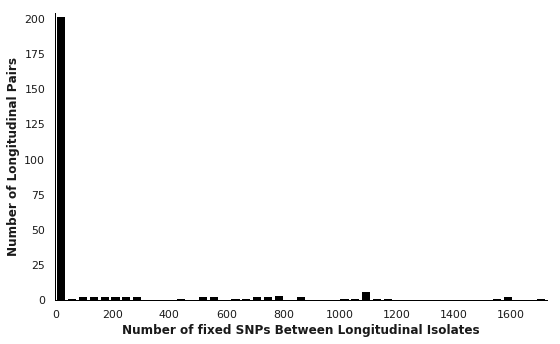

In [26]:
SNP_diff_threshold = 3

plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

#plot all pairwise comparisons
n , bins , patches = plt.hist(num_fSNPs_per_isolate_pair , bins = 45 , color = 'black' , rwidth = 0.75 , edgecolor='black', linewidth = 0.0)

plot_padding = 3

total_number_of_patients = np.shape( num_fSNPs_per_isolate_pair )[0]

plt.ylabel('Number of Longitudinal Pairs' , fontweight = 'bold' , fontsize = 12, color = 'k')
plt.xlabel('Number of fixed SNPs Between Longitudinal Isolates', fontweight = 'bold', fontsize = 12 , color = 'k')

plt.xlim(min(bins)-plot_padding , max(bins)+plot_padding)
plt.ylim(min(n) , max(n)+3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(8.0, 5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/Filtering_by_fSNPs_analysis/pairwise_fSNP_distance_between_longitudinal_isolates.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

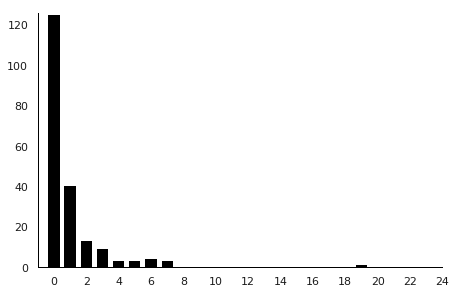

In [27]:
SNP_diff_threshold = 25

plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots()

#plot all pairwise comparison
n , bins , patches = plt.hist( num_fSNPs_per_isolate_pair[num_fSNPs_per_isolate_pair <= SNP_diff_threshold] , bins = np.arange(0 , SNP_diff_threshold + 1) , color = 'black' , rwidth = 0.7 , edgecolor='black', linewidth=0.0 , align = 'left')

plot_padding = 1.0

total_number_of_patients = np.shape( num_fSNPs_per_isolate_pair )[0]

plt.xlim(min(bins)-plot_padding , max(bins)-plot_padding)
plt.ylim(min(n) , max(n)+1)



ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')

ax.set_xticks(bins[0:-1][0:len(bins[0:-1]):2]) #xtick positions
ax.set_xticklabels([str(int(x)) for x in bins[0:][0:len(bins[0:]):2]]) #xtick labels

fig = plt.gcf()
fig.set_size_inches(6.5, 4.25)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/Filtering_by_fSNPs_analysis/pairwise_fSNP_distance_between_longitudinal_isolates_ZOOMED.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

### *Filter* out Longitudinal Pairs that have > 7 SNPs between them

#### Drop mixed isolate pairs from Sample Annotation and export as CSV

In [28]:
print np.shape(sample_annotation)[0] / 2 #number of longitudinal isolate pairs

244


In [29]:
#get list of isolate pairs with a high genetic distance
mixed_isolate_pairs = list( num_fSNPs_per_isolate_pair[num_fSNPs_per_isolate_pair > 7].index )

#filter out from sample annotation
clean_isolate_pairs = list( set(list(sample_annotation.index)) - set(mixed_isolate_pairs) )

sample_annotation_clean = sample_annotation.loc[clean_isolate_pairs , :]

In [30]:
print np.shape(sample_annotation_clean)[0] / 2 #number of longitudinal isolate pairs with fSNP distance <= 7

200


Export updated sample annotation file

In [31]:
sample_annotation_clean.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_fastq_path_names_and_JankyPipe_tags_filtered_final.csv' , sep = ',')

In [32]:
sample_annotation_clean.head()

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039337,NaN,1,ERR039337,longitudinal
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039338,NaN,2,ERR039338,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMJA00000000,Peru5115,1,Peru5115,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMPC00000000,Peru4668,2,Peru4668,longitudinal
2491,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMZT00000000,Peru4903,1,Peru4903,longitudinal


#### Also Export Sample Annotation to CSV for modifying by inclusion of times between isolate collection

In [33]:
sample_annotation_clean.drop(labels = ['fastq_files'] , axis = 1 , inplace = True)
sample_annotation_clean_for_times = sample_annotation_clean.copy()
sample_annotation_clean_for_times['patient_id'] = list(sample_annotation_clean_for_times.index)
sample_annotation_clean_for_times.reset_index(inplace = True , drop = True)
sample_annotation_clean_for_times.sort_values(by = ['population' , 'patient_id' , 'sample_order'] , inplace = True)
sample_annotation_clean_for_times.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_sample_annotation_for_temporal_analysis.csv' , sep  = ',')

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Distribution of Lineages (across filtered longitudinal sample pairs)

#### Parse & Scrape lineage calls

In [34]:
sample_annotation_clean.head()

,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,
P000183,WALKER,ERR039337,NaN,1,ERR039337,longitudinal
P000183,WALKER,ERR039338,NaN,2,ERR039338,longitudinal
1960,CETR,MMJA00000000,Peru5115,1,Peru5115,longitudinal
1960,CETR,MMPC00000000,Peru4668,2,Peru4668,longitudinal
2491,CETR,MMZT00000000,Peru4903,1,Peru4903,longitudinal


In [9]:
#dataframe that stores the lienage calls for each isolate
lineage_call_DF = pd.DataFrame(index = range(0 , 2) , columns = ['population' , 'patient_id' , 'tag' , 'lineage_1' , 'lineage_2', 'lineage_3' , 'lineage_4' , 'decision'])


for isolate_index in range(0, np.shape(sample_annotation_clean)[0]):

    population = sample_annotation_clean.iloc[isolate_index , 0]
    patient_id = str(sample_annotation_clean.iloc[isolate_index , :].name)
    tag = sample_annotation_clean.iloc[isolate_index , 4] #folder title in JankyPipe output directory
    
    #lineage_call_file
    lineage_call_txt = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/JankyPipe/output/' + tag + '/fast-lineage-caller/lineage_call.txt'
    
    #read in text file that stores the lineage call
    f = open(lineage_call_txt,'r')
    lineage_call_string = f.readline()

    #store population, patient_id and sample_id in DF
    lineage_call_DF.ix[isolate_index , 0] = population
    lineage_call_DF.ix[isolate_index , 1] = patient_id
    lineage_call_DF.ix[isolate_index , 2] = tag

    #store full output / decision
    lineage_call_DF.ix[isolate_index , 7] = lineage_call_string

    for specific_lineage_call in lineage_call_string.split('lineage')[1:]:

        specific_lineage_call = specific_lineage_call.replace(',', '')
        specific_lineage_call = specific_lineage_call.replace('\n', '')

        #lineage_call_number can be determined by number of periods in lineage call
        #if 0 -> lineage call 1, if 1 -> lineage call 2, etc.
        lineage_call_number = specific_lineage_call.count('.')

        #store lineage_call
        lineage_call_DF.ix[isolate_index , 3 + lineage_call_number] = specific_lineage_call
                
#make the patient_ids the index
lineage_call_DF.set_index(keys = 'patient_id' , drop = True , inplace = True)

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [10]:
lineage_call_DF.head()

,population,tag,lineage_1,lineage_2,lineage_3,lineage_4,decision
patient_id,,,,,,,
P000183,WALKER,ERR039337,4,4.3,4.3.1,NaN,"--decision: lineage4,lineage4.3,lineage4.3.1\n"
P000183,WALKER,ERR039338,4,4.3,4.3.1,NaN,"--decision: lineage4,lineage4.3,lineage4.3.1\n"
1960,CETR,Peru5115,4,NaN,NaN,NaN,--decision: lineage4\n
1960,CETR,Peru4668,4,NaN,NaN,NaN,--decision: lineage4\n
2491,CETR,Peru4903,4,4.3,4.3.3,NaN,"--decision: lineage4,lineage4.3,lineage4.3.3\n"


In [37]:
lineage_call_per_patient = lineage_call_DF.copy()
lineage_call_per_patient.loc[: , 'patient_id'] = list( lineage_call_per_patient.index )
lineage_call_per_patient.drop_duplicates(subset=['population' , 'patient_id' , 'decision'], keep='first' , inplace = True)

In [38]:
patient_lineage_DF = lineage_call_per_patient.loc[: , ['population']]
lineage_assignments = []
                                                       
#find most precise lineage for each patient
for row_index in range(0 , np.shape(lineage_call_per_patient)[0]):
    patient_information = lineage_call_per_patient.ix[row_index , :]
    patient_id = patient_information.name
    
    lineage_call = patient_information.lineage_1 #set as default
    for lineage in [patient_information.lineage_2 , patient_information.lineage_3 , patient_information.lineage_4]:
                                                       
        #check to see if nan value
        if pd.isnull(lineage) == False:
            lineage_call = lineage
        elif pd.isnull(lineage) == True:
            break
        
    lineage_assignments.append(lineage_call)
                                                       
patient_lineage_DF.loc[: , 'lineage_call'] = lineage_assignments

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [39]:
patient_lineage_DF.head()

,population,lineage_call
patient_id,,
P000183,WALKER,4.3.1
1960,CETR,4
2491,CETR,4.3.3
2968,CETR,4.8
2020E,BRYANT,2.2.1.1


In [40]:
patient_lineage_DF.loc[: , 'overall_lineage_call'] = [lineage_i[0] for lineage_i in list(patient_lineage_DF.lineage_call)]

In [41]:
unique_lineage_calls = set( list( patient_lineage_DF.overall_lineage_call ) )

In [42]:
list( unique_lineage_calls )

['1', '3', '2', '5', '4']

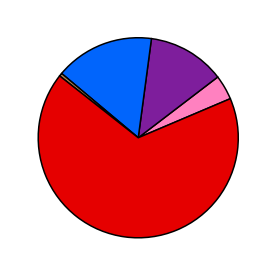

In [43]:
pie_slice_proportions = []
labels = []
colors = []

for lineage_call in unique_lineage_calls:
    
    proportion = float(list( patient_lineage_DF.overall_lineage_call ).count(lineage_call)) / float(len(list( patient_lineage_DF.overall_lineage_call )))
    pie_slice_proportions.append(proportion)
    labels.append(lineage_call)
    
    if lineage_call[0] == '1':
        colors.append('xkcd:pink')
    if lineage_call[0] == '2':
        colors.append('xkcd:bright blue')
    if lineage_call[0] == '3':
        colors.append('xkcd:purple')
    if lineage_call[0] == '4':
        colors.append('xkcd:red')
    if lineage_call[0] == '5':
        colors.append('xkcd:light brown')
        
# Make square figures and axes
the_grid = GridSpec(1, 1)

fig, ax = plt.subplots()

wedges, texts = ax.pie(pie_slice_proportions, shadow=False , colors = colors , wedgeprops = {'linewidth': 12 } , labeldistance = 1.1 , startangle = 23)

fig = plt.gcf()
fig.set_size_inches(4, 4)
fig.tight_layout()

for w in wedges:
    w.set_linewidth(1.5)
    w.set_edgecolor('black')
    
#for text in texts:
#    text.set_rotation(0)

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/Sample_Summary/Global_Lineage_Distribution_across_subjects.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)
    
plt.show()

### Distribution of Samples

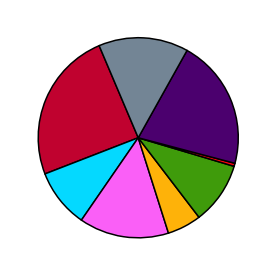

In [44]:
patient_popualtion_tags = list( patient_lineage_DF.population )
population_IDs = ['CETR' , 'CASALI' , 'WALKER' , 'TRAUNER', 'WITNEY' , 'XU' , 'GUERRA' , 'BRYANT']

pie_slice_proportions = []
labels = []
colors = []
sample_sizes = []

for population_id in population_IDs:
    
    proportion = float(list( patient_popualtion_tags ).count(population_id)) / float(len(patient_popualtion_tags))
    pie_slice_proportions.append(proportion)
    sample_size = str( list( patient_popualtion_tags ).count(population_id) )
    
    labels.append(population_id + '\n' + 'N = ' + sample_size)
    
    
    if population_id == 'CETR':
        colors.append('xkcd:lipstick red')
    if population_id == 'CASALI':
        colors.append('xkcd:neon blue')
    if population_id == 'WALKER':
        colors.append('xkcd:light magenta')
    if population_id == 'TRAUNER':
        colors.append('xkcd:saffron')
    if population_id == 'WITNEY':
        colors.append('xkcd:grass green')
    if population_id == 'XU':
        colors.append('xkcd:bright red')
    if population_id == 'GUERRA':
        colors.append('xkcd:royal purple')
    if population_id == 'BRYANT':
        colors.append('xkcd:steel')
        
# Make square figures and axes

the_grid = GridSpec(1, 1)

fig, ax = plt.subplots()

wedges, texts = ax.pie(pie_slice_proportions, shadow=False , colors = colors , wedgeprops = {'linewidth': 8 } , labeldistance = 0.50 , startangle = 113)

fig = plt.gcf()
fig.set_size_inches(4, 4)
fig.tight_layout()

for w in wedges:
    w.set_linewidth(1.5)
    w.set_edgecolor('black')
    
for text in texts:
    text.set_fontsize(10)
    
file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/Sample_Summary/sample_study_distribution_across_subjects.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

##########################################################################################################################################################################################################################################

## Replicate Sample Pairs

##########################################################################################################################################################################################################################################

#### Import Sample Annotation file

In [45]:
sample_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Replicate_fastq_path_names_and_JankyPipe_tags_filtered_with_Kraken_and_F2.csv' , sep  = ',').set_index('patient_id')

In [46]:
SNP_variant_dir = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/replicate_SNPs/all_SNPs_between_replicate_pairs/'

In [47]:
sample_annotation.head()

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
replicate_pair_61,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMOI00000000,Peru4688,0,Peru4688,replicate
replicate_pair_61,/n/data1/hms/dbmi/farhat/fastq_db/pools/99-R86...,CP_REP,NaN,99-R862,0,99-R862,replicate
replicate_pair_19,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMKP00000000,Peru5074,0,Peru5074,replicate
replicate_pair_19,/n/data1/hms/dbmi/farhat/fastq_db/pools/01-R08...,CP_REP,NaN,01-R0878,0,01-R0878,replicate
replicate_pair_21,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMZA00000000,Peru4922,0,Peru4922,replicate


In [48]:
num_isolate_pair_IDs = np.shape(sample_annotation)[0] / 2
print num_isolate_pair_IDs 

70


In [49]:
isolate_pair_ID_list = list(set(sample_annotation.index))

### Call function to collect SNPs passing Difference in Alternate Allele Frequency Threshold

In [50]:
Base_Call_variants_btwn_isolates_big_change_in_alt_AF = []

isolate_pair_index = 0

#iterate through isolate pairs, collect all SNP variants arising between each pair of isolates
for isolate_pair_ID in isolate_pair_ID_list:
    
    #retrieve filtered paired Base Calls with a change in Alternate Allele Frequency > threshold
    Base_Call_variants_btwn_isolates_big_change_in_alt_AF_pair_i = get_filtered_SNPs_between_isolates(isolate_pair_ID , alt_AF_diff_threshold)
    
    #store relevant Base Call info in list of DataFrames (1 for each isolate pair)
    Base_Call_variants_btwn_isolates_big_change_in_alt_AF.append(Base_Call_variants_btwn_isolates_big_change_in_alt_AF_pair_i)
    isolate_pair_index += 1
    
    if isolate_pair_index % 5 == 0:
        print isolate_pair_index
        
#concatenate DataFrames for each subject into 1 DataFrame
Base_Call_variants_btwn_isolates_big_change_in_alt_AF = pd.concat(Base_Call_variants_btwn_isolates_big_change_in_alt_AF , axis = 0)

Base_Call_variants_btwn_isolates_big_change_in_alt_AF.reset_index(inplace = True , drop = True)

5
10
15
20
25
30
35
40
45
50
55
60
65
70


### *Filter*: Drop paired Base Calls if both Base Calls in a pair support *different* Alternate Alleles

In [51]:
#list that stores the indices of paired Base Calls with DIFFERENT Alternate Alleles
Base_Calls_to_Drop = []

#iterate through each PAIR of corresponding Base Calls from paired isolates
for isolate_A_Base_Call_i , isolate_B_Base_Call_i in zip(range(0 , np.shape(Base_Call_variants_btwn_isolates_big_change_in_alt_AF)[0] , 2) , range(1 , np.shape(Base_Call_variants_btwn_isolates_big_change_in_alt_AF)[0] , 2) ):
    
    #pull info that both Base Calls should have in COMMON
    isolate_A_Base_Call_info = list( Base_Call_variants_btwn_isolates_big_change_in_alt_AF.loc[isolate_A_Base_Call_i , ['ref_base','ref_position','gene_id','genomic_coord','population','patient_id']] ) 
    isolate_B_Base_Call_info = list( Base_Call_variants_btwn_isolates_big_change_in_alt_AF.loc[isolate_B_Base_Call_i , ['ref_base','ref_position','gene_id','genomic_coord','population','patient_id']] ) 
    
    #make sure Base Calls Match with respect to Reference Base, Reference Position, gene ID, Genomic Coordinate, Gene Category, Symbol, Population & Patient ID
    if isolate_A_Base_Call_info == isolate_B_Base_Call_info:
        
        #pull alternate Allele for each of the paired isolates
        isolate_A_Alt_Base = Base_Call_variants_btwn_isolates_big_change_in_alt_AF.loc[isolate_A_Base_Call_i , 'alt_base']
        isolate_B_Alt_Base = Base_Call_variants_btwn_isolates_big_change_in_alt_AF.loc[isolate_B_Base_Call_i , 'alt_base']
        
        #Check to see if there is a 'Z' in the pair of Alternate Alleles, if so one of the Base Calls supported the Reference Base (so there was no Alternate Allele)
        if (isolate_A_Alt_Base == 'Z') or (isolate_B_Alt_Base == 'Z'):
            pass
        
        #if neither Alternate Allele is a 'Z', then check to see that the Alternate Allele Bases Match
        elif isolate_A_Alt_Base == isolate_B_Alt_Base:
            pass
        
        #if the Alternate Alleles DON'T match and both Base Calls supported Alternate Alleles (not the Reference), then we can't compare the Allele Frequencies of these Alternate Alleles (since they're different)
        else:
            Base_Calls_to_Drop = Base_Calls_to_Drop + [isolate_A_Base_Call_i , isolate_B_Base_Call_i]
        
    #print indices of Base Calls and see what went wrong if the paired Base Calls have different information that the Calls should have in Common (Ref Position, Ref Base, Gene ID, Patient ID, etc.)
    else:
        print (isolate_A_Base_Call_i , isolate_B_Base_Call_i)
        
#Drop Paired Base Calls that supported different Alternate Alleles
Base_Call_variants_btwn_isolates_big_change_in_alt_AF.drop(Base_Calls_to_Drop , axis = 0 , inplace = True)

#reset index
Base_Call_variants_btwn_isolates_big_change_in_alt_AF.reset_index(inplace = True, drop = True)

In [52]:
Base_Call_variants_btwn_isolates_big_change_in_alt_AF.head(n = 10)

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change
0,C,Z,7691,1203,Ref_PASS,[],"{u'QP': [0, 100, 0, 0], u'AC': [0], u'AF': [0....",0.00,34,01-R0878,CP_REP,replicate_pair_19,Rv0006,390,Antibiotic Resistance,None,None,None
1,C,G,7691,6639,Alt_PASS,[],"{u'QP': [0, 0, 100, 0], u'AC': [2], u'AF': [1....",1.00,168,Peru5074,CP_REP,replicate_pair_19,Rv0006,390,Antibiotic Resistance,None,S,T130T
2,G,Z,8040,1703,Ref_PASS,[],"{u'QP': [0, 0, 100, 0], u'AC': [0], u'AF': [0....",0.00,46,01-R0878,CP_REP,replicate_pair_19,Rv0006,739,Antibiotic Resistance,None,None,None
3,G,A,8040,6781,Alt_PASS,[],"{u'QP': [99, 0, 1, 0], u'AC': [2], u'AF': [0.9...",0.99,178,Peru5074,CP_REP,replicate_pair_19,Rv0006,739,Antibiotic Resistance,None,N,G247S
4,C,T,11370,2031,Alt_PASS,[],"{u'QP': [0, 0, 0, 100], u'AC': [2], u'AF': [1....",1.00,59,01-R0878,CP_REP,replicate_pair_19,Rvnt02_Rv0008c,None,None,None,I,None
5,C,Z,11370,6705,Ref_PASS,[],"{u'QP': [0, 100, 0, 0], u'AC': [0], u'AF': [0....",0.00,170,Peru5074,CP_REP,replicate_pair_19,Rvnt02_Rv0008c,None,None,None,I,None
6,G,A,14251,6315,Alt_PASS,[],"{u'QP': [100, 0, 0, 0], u'AC': [2], u'AF': [1....",1.00,161,Peru5074,CP_REP,replicate_pair_19,Rv0012,163,Antigen,None,N,D55N
7,G,Z,14251,1611,Ref_PASS,[],"{u'QP': [0, 0, 100, 0], u'AC': [0], u'AF': [0....",0.00,46,01-R0878,CP_REP,replicate_pair_19,Rv0012,163,Antigen,None,None,None
8,G,Z,17608,2279,Ref_PASS,[],"{u'QP': [0, 0, 100, 0], u'AC': [0], u'AF': [0....",0.00,65,01-R0878,CP_REP,replicate_pair_19,Rv0015c,1155,Antigen,None,None,None
9,G,C,17608,5244,Alt_PASS,[],"{u'QP': [0, 99, 1, 0], u'AC': [2], u'AF': [0.9...",0.99,149,Peru5074,CP_REP,replicate_pair_19,Rv0015c,1155,Antigen,None,N,S385R


In [53]:
np.shape(Base_Call_variants_btwn_isolates_big_change_in_alt_AF)

(7590, 18)

### Re-Shape Filtered DataFrame (Paired Base Calls across all isolate pairs) to store one entry per SNP

In [54]:
SNP_variants_between_paired_isolates = pd.DataFrame()

#common information to both Base Calls (can just look at isolate A)
population_dict = {}
patient_id_dict = {}
ref_position_dict = {}
ref_allele_dict = {}
gene_id_dict  = {}
genomic_coord_dict = {}
gene_category_dict = {}
gene_symbol_dict = {}

#look at info for both Base Calls
alt_allele_dict = {}
alt_AF_diff_dict = {}
SNP_type_dict = {}
AA_change_dict = {}

SNP_index = 0
#iterate through indices for isolate A (store common information for isolate pair A & B came from and Base Call), calculate different in Alternate Allele Frequencies, store Syn or NSyn info
for even_index in range(0 , np.shape(Base_Call_variants_btwn_isolates_big_change_in_alt_AF)[0] , 2):
    
    #Base Call info for isolate A
    Base_Call_info_isolate_A = Base_Call_variants_btwn_isolates_big_change_in_alt_AF.loc[even_index , :]
    #Base Call info for isolate B
    Base_Call_info_isolate_B = Base_Call_variants_btwn_isolates_big_change_in_alt_AF.loc[even_index+1 , :]
    
    population_dict[SNP_index] = Base_Call_info_isolate_A.population
    patient_id_dict[SNP_index] = Base_Call_info_isolate_A.patient_id
    ref_position_dict[SNP_index] = Base_Call_info_isolate_A.ref_position
    ref_allele_dict[SNP_index] = Base_Call_info_isolate_A.ref_base
    gene_id_dict[SNP_index] = Base_Call_info_isolate_A.gene_id
    genomic_coord_dict[SNP_index] = Base_Call_info_isolate_A.gene_coord
    gene_category_dict[SNP_index] = Base_Call_info_isolate_A.gene_category
    gene_symbol_dict[SNP_index] = Base_Call_info_isolate_A.gene_symbol
    
    #get alternate allele
    alt_allele_calls = [Base_Call_info_isolate_A.alt_base , Base_Call_info_isolate_B.alt_base]
    try:
        alt_allele_calls.remove('Z')
    except ValueError:
        pass
    alt_allele_dict[SNP_index] = alt_allele_calls[0]

    #get difference in Alternate Allele Frequencies
    alt_AF_diff_dict[SNP_index] = abs(Base_Call_info_isolate_A.alt_AF - Base_Call_info_isolate_B.alt_AF)
    
    #get type of SNP 
    if 'S' in [Base_Call_info_isolate_A.SNP_ftype , Base_Call_info_isolate_B.SNP_ftype]:
        SNP_type_dict[SNP_index] = 'S'
        
    elif 'N' in [Base_Call_info_isolate_A.SNP_ftype , Base_Call_info_isolate_B.SNP_ftype]:
        SNP_type_dict[SNP_index] = 'N'
        
    elif 'I' in [Base_Call_info_isolate_A.SNP_ftype , Base_Call_info_isolate_B.SNP_ftype]:
        SNP_type_dict[SNP_index] = 'I'
        
    #get AA change
    AA_change_calls = [Base_Call_info_isolate_A.AA_change , Base_Call_info_isolate_B.AA_change]
    try:
        AA_change_calls.remove('None')
    except ValueError:
        pass
    AA_change_dict[SNP_index] = AA_change_calls[0]
        
    SNP_index += 1
    
#convert dictionaries into series
population = pd.Series(population_dict)
patient_id = pd.Series(patient_id_dict)
ref_position = pd.Series(ref_position_dict)
ref_allele = pd.Series(ref_allele_dict)
alt_allele = pd.Series(alt_allele_dict)
gene_id = pd.Series(gene_id_dict)
genomic_coord = pd.Series(genomic_coord_dict)
gene_category = pd.Series(gene_category_dict)
gene_symbol = pd.Series(gene_symbol_dict)
alt_AF_diff = pd.Series(alt_AF_diff_dict)
SNP_type = pd.Series(SNP_type_dict)
AA_change = pd.Series(AA_change_dict)
        
#create DataFrame
SNP_variants_between_paired_isolates['population'] = population
SNP_variants_between_paired_isolates['patient_id'] = patient_id
SNP_variants_between_paired_isolates['ref_position'] = ref_position 
SNP_variants_between_paired_isolates['ref_allele'] = ref_allele
SNP_variants_between_paired_isolates['alt_allele'] = alt_allele
SNP_variants_between_paired_isolates['gene_id'] = gene_id
SNP_variants_between_paired_isolates['genomic_coord'] = genomic_coord
SNP_variants_between_paired_isolates['gene_category'] = gene_category
SNP_variants_between_paired_isolates['gene_symbol'] = gene_symbol
SNP_variants_between_paired_isolates['alt_AF_diff'] = alt_AF_diff
SNP_variants_between_paired_isolates['SNP_type'] = SNP_type
SNP_variants_between_paired_isolates['AA_change'] = AA_change

In [55]:
SNP_variants_between_paired_isolates.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
0,CP_REP,replicate_pair_19,7691,C,G,Rv0006,390,Antibiotic Resistance,None,1.00,S,T130T
1,CP_REP,replicate_pair_19,8040,G,A,Rv0006,739,Antibiotic Resistance,None,0.99,N,G247S
2,CP_REP,replicate_pair_19,11370,C,T,Rvnt02_Rv0008c,None,None,None,1.00,I,None
3,CP_REP,replicate_pair_19,14251,G,A,Rv0012,163,Antigen,None,1.00,N,D55N
4,CP_REP,replicate_pair_19,17608,G,C,Rv0015c,1155,Antigen,None,0.99,N,S385R


In [56]:
np.shape(SNP_variants_between_paired_isolates)

(3795, 12)

In [57]:
isolate_pairs = list(set( sample_annotation.index ))

num_fSNPs_per_isolate_pair = {}
for isolate_pair in isolate_pairs:
    
    num_fSNPs_per_isolate_pair[isolate_pair] = np.shape(SNP_variants_between_paired_isolates[SNP_variants_between_paired_isolates.patient_id == isolate_pair])[0]
    
#convert dict to series
num_fSNPs_per_isolate_pair = pd.Series(num_fSNPs_per_isolate_pair)

#sort values
num_fSNPs_per_isolate_pair.sort_values(ascending = False , inplace = True)

num_fSNPs_per_isolate_pair.head(n=50)

replicate_pair_54    1094
replicate_pair_8      775
replicate_pair_19     734
replicate_pair_41     424
replicate_pair_57     286
replicate_pair_58     170
I0003922-7            156
I0003710-6            155
replicate_pair_68       1
replicate_pair_9        0
replicate_pair_24       0
replicate_pair_21       0
replicate_pair_22       0
replicate_pair_23       0
replicate_pair_27       0
replicate_pair_25       0
replicate_pair_26       0
replicate_pair_28       0
replicate_pair_29       0
replicate_pair_3        0
replicate_pair_30       0
replicate_pair_2        0
replicate_pair_16       0
replicate_pair_18       0
replicate_pair_33       0
replicate_pair_15       0
replicate_pair_14       0
replicate_pair_13       0
replicate_pair_12       0
replicate_pair_11       0
replicate_pair_10       0
replicate_pair_1        0
replicate_pair_0        0
P12_3                   0
P12_2                   0
P12_1                   0
I0004220-5              0
replicate_pair_32       0
replicate_pa

Copy series for down-stream analysis

In [58]:
num_fSNPs_per_replicate_isolate_pair = num_fSNPs_per_isolate_pair.copy()

### *Subset* to the isolate pairs that we're going to drop (at threshold of > 7 SNPs)

In [59]:
isolate_pair_IDs_for_dropped_isolates = list( set( list( num_fSNPs_per_isolate_pair[num_fSNPs_per_isolate_pair > 7].index ) ) )

In [60]:
print isolate_pair_IDs_for_dropped_isolates

['replicate_pair_19', 'replicate_pair_8', 'I0003922-7', 'replicate_pair_54', 'replicate_pair_57', 'replicate_pair_41', 'I0003710-6', 'replicate_pair_58']


In [61]:
len(isolate_pair_IDs_for_dropped_isolates)

8

In [62]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(sample_annotation.loc[isolate_pair_IDs_for_dropped_isolates , :].sort_values('population'))

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
replicate_pair_19,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMKP00000000,Peru5074,0,Peru5074,replicate
replicate_pair_19,/n/data1/hms/dbmi/farhat/fastq_db/pools/01-R08...,CP_REP,NaN,01-R0878,0,01-R0878,replicate
replicate_pair_8,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMOZ00000000,Peru4671,0,Peru4671,replicate
replicate_pair_8,/n/data1/hms/dbmi/farhat/fastq_db/pools/01-R01...,CP_REP,NaN,01-R0185,0,01-R0185,replicate
replicate_pair_54,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMSH00000000,Peru4574,0,Peru4574,replicate
replicate_pair_54,/n/data1/hms/dbmi/farhat/fastq_db/pools/04-R02...,CP_REP,NaN,04-R0266,0,04-R0266,replicate
replicate_pair_57,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMUQ00000000,Peru5037,0,Peru5037,replicate
replicate_pair_57,/n/data1/hms/dbmi/farhat/fastq_db/pools/98-R79...,CP_REP,NaN,98-R790,0,98-R790,replicate
replicate_pair_41,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MRFD00000000,Peru5442,0,Peru5442,replicate


In [63]:
from collections import Counter
Counter(list(sample_annotation.loc[isolate_pair_IDs_for_dropped_isolates , :].population))

Counter({'CP_REP': 12, 'LC_REP': 4})

### Distribution of pairwise distances across isolate pairs

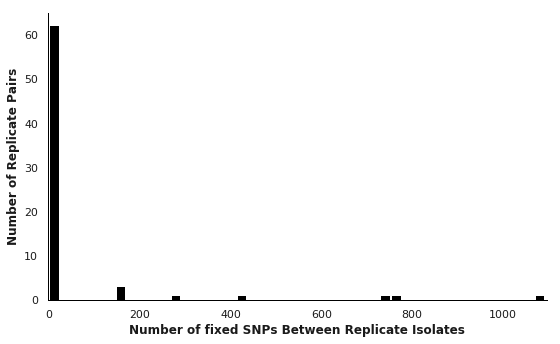

In [64]:
SNP_diff_threshold = 3

plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

#plot all pairwise comparisons
n , bins , patches = plt.hist(num_fSNPs_per_isolate_pair , bins = 45 , color = 'black' , rwidth = 0.75 , edgecolor='black', linewidth = 0.0)

plot_padding = 3

total_number_of_patients = np.shape( num_fSNPs_per_isolate_pair )[0]

plt.ylabel('Number of Replicate Pairs' , fontweight = 'bold' , fontsize = 12, color = 'k')
plt.xlabel('Number of fixed SNPs Between Replicate Isolates', fontweight = 'bold', fontsize = 12 , color = 'k')

plt.xlim(min(bins)-plot_padding , max(bins)+plot_padding)
plt.ylim(min(n) , max(n)+3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(8.0, 5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/Filtering_by_fSNPs_analysis/pairwise_fSNP_distance_between_replicate_isolates.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

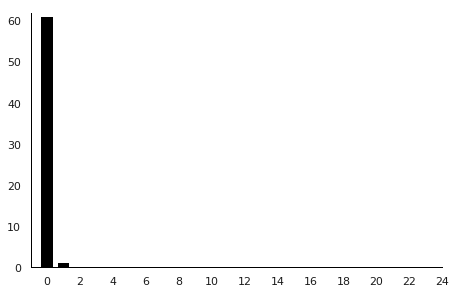

In [65]:
SNP_diff_threshold = 25

plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots()

#plot all pairwise comparison
n , bins , patches = plt.hist( num_fSNPs_per_isolate_pair[num_fSNPs_per_isolate_pair <= SNP_diff_threshold] , bins = np.arange(0 , SNP_diff_threshold + 1) , color = 'black' , rwidth = 0.7 , edgecolor='black', linewidth=0.0 , align = 'left')

plot_padding = 1.0

total_number_of_patients = np.shape( num_fSNPs_per_isolate_pair )[0]

plt.xlim(min(bins)-plot_padding , max(bins)-plot_padding)
plt.ylim(min(n) , max(n)+1)



ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')

ax.set_xticks(bins[0:-1][0:len(bins[0:-1]):2]) #xtick positions
ax.set_xticklabels([str(int(x)) for x in bins[0:][0:len(bins[0:]):2]]) #xtick labels

fig = plt.gcf()
fig.set_size_inches(6.5, 4.25)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/Filtering_by_fSNPs_analysis/pairwise_fSNP_distance_between_replicate_isolates_ZOOMED.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

### *Filter* out Replicate Pairs that have > 7 SNPs between them

#### Drop mixed isolate pairs from Sample Annotation and export as CSV

In [66]:
print np.shape(sample_annotation)[0] / 2 #number of replicate isolate pairs

70


In [67]:
#get list of isolate pairs with a high genetic distance
mixed_isolate_pairs = list( num_fSNPs_per_isolate_pair[num_fSNPs_per_isolate_pair > 7].index )

#filter out from sample annotation
clean_isolate_pairs = list( set(list(sample_annotation.index)) - set(mixed_isolate_pairs) )

sample_annotation_clean = sample_annotation.loc[clean_isolate_pairs , :]

In [68]:
print np.shape(sample_annotation_clean)[0] / 2 #number of replicate isolate pairs with fSNP distance <= 7

62


Export updated sample annotation file

In [69]:
sample_annotation_clean.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Replicate_fastq_path_names_and_JankyPipe_tags_filtered_final.csv' , sep = ',')

In [70]:
sample_annotation_clean.head()

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
replicate_pair_18,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMYK00000000,Peru4938,0,Peru4938,replicate
replicate_pair_18,/n/data1/hms/dbmi/farhat/fastq_db/pools/01-R07...,CP_REP,NaN,01-R0774,0,01-R0774,replicate
replicate_pair_26,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMGW00000000,Peru4719,0,Peru4719,replicate
replicate_pair_26,/n/data1/hms/dbmi/farhat/fastq_db/pools/01-R09...,CP_REP,NaN,01-R0909,0,01-R0909,replicate
replicate_pair_11,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CP_REP,MMOR00000000,Peru4679,0,Peru4679,replicate


##########################################################################################################################################################################################################################################

## Longitudinal & Replicate Isolate Pairs

##########################################################################################################################################################################################################################################

### Plot the distribution of fSNPs between all *Replicate* and *Longitudinal* Isolate Pairs on the same plot

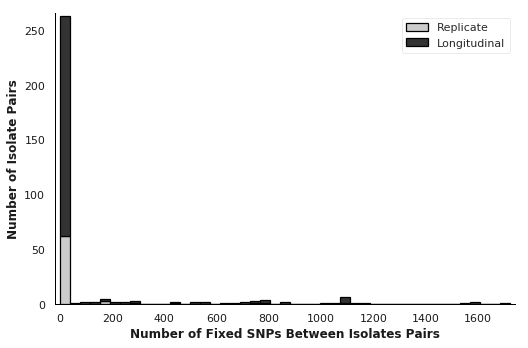

In [71]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=2
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots()

#get the fSNP distances for all replicate isolates
fSNP_replicate_values = num_fSNPs_per_replicate_isolate_pair.values

#get the fSNPs distances for all longitudinal isolates
fSNP_longitudinal_values = num_fSNPs_per_longitudinal_isolate_pair.values

#plot all pairwise comparisons
n , bins , patches = plt.hist([fSNP_replicate_values , fSNP_longitudinal_values] , bins = 45 , color = ['0.80' , '0.20'] , rwidth = 1.0 , edgecolor='black', linewidth=1.25 , stacked = True , label = ['Replicate','Longitudinal'])

plot_padding = 20

plt.ylabel('Number of Isolate Pairs' , fontweight = 'bold' , fontsize = 12, color = 'k')
plt.xlabel('Number of Fixed SNPs Between Isolates Pairs', fontweight = 'bold', fontsize = 12 , color = 'k')

plt.xlim(np.min(bins)-plot_padding , np.max(bins)+plot_padding)
plt.ylim(np.min(n) , np.max(n)+3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(loc='upper right')
ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.0)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/Filtering_by_fSNPs_analysis/pairwise_fSNP_distance_between_isolate_pairs.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

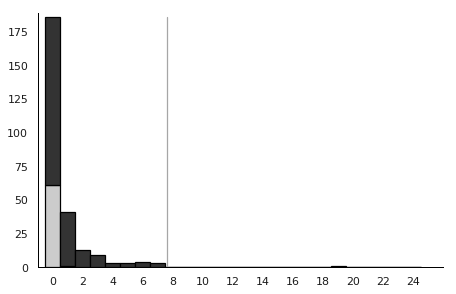

In [72]:
fig, ax = plt.subplots()

#get the fSNP distances for all replicate isolates
fSNP_replicate_values = num_fSNPs_per_replicate_isolate_pair.values

#get the fSNPs distances for all longitudinal isolates
fSNP_longitudinal_values = num_fSNPs_per_longitudinal_isolate_pair.values

#plot all pairwise comparisons
n , bins , patches = plt.hist([fSNP_replicate_values[fSNP_replicate_values <= 25] , fSNP_longitudinal_values[fSNP_longitudinal_values <= 25]] , bins = np.arange(0 , 25 + 1) , color = ['0.80' , '0.20'] , rwidth = 1.0 , edgecolor='black', linewidth=1.25 , stacked = True , label = ['Replicate','Longitudinal'], align = 'left')

plot_padding = 1.0
plt.plot([7.6 , 7.6] , [0 , np.max(n)] , color = '0.65' , linewidth = 1.25 , linestyle = '-')


plt.xlim(np.min(bins)-plot_padding , np.max(bins)+plot_padding)
plt.ylim(np.min(n) , np.max(n)+3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks(bins[0:-1][0:len(bins[0:-1]):2]) #xtick positions
ax.set_xticklabels([str(int(x)) for x in bins[0:][0:len(bins[0:]):2]]) #xtick labels
ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(6.5, 4.25)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/Filtering_by_fSNPs_analysis/pairwise_fSNP_distance_between_isolate_pairs_ZOOMED.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()